# 0. Setup.

In [1]:
%pip install -r ../../requirements_ai-prac.txt

Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

# 1. Data.

In [46]:
# Load.
df = pd.read_csv('data/train.csv')

# Drop `id` column.
df = df.drop(columns=['id'])

# Split into X and y.
X  = df.drop(columns=['BeatsPerMinute'])
y  = df['BeatsPerMinute']

# Display.
display(df.head())

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# 2. EDA.

- Observations.
  - Most features are in ***near-normal*** distribution.
  - Some features show right skewed a bit, consider transform.
    - `InstrumentalScore`
    - `VocalContent`
    - `AcousticQuality`
  - No feature shows heavy-tailed distribution.
  - Label `BeatsPerMinute` shows textbook distribution.

- Conclusions.
  - Apply `log1p` on 3 skewed features.
    - `InstrumentalScore`
    - `VocalContent`
    - `AcousticQuality`
  - Just apply `StandardScaler` for all features.
  - Need to model `polynomial` relationships, not linear.

## 2.1. Null Handling.

- No single null value in any column.
- Seems like it is well-structured tabular dataset for practice.
- Let's suppose there is no noise for now.

In [ ]:
display(df.head(10))
display(df.info())

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511
5,0.594579,-11.715431,0.101701,0.000005,0.259634,0.024300,0.639254,161012.2221,0.938333,151.43602
6,0.714958,-8.809725,0.023500,0.471139,0.000001,0.356775,0.724783,243432.5794,0.336800,151.63439
7,0.703726,-10.482610,0.037751,0.115727,0.000001,0.024300,0.773899,293848.8919,0.722000,123.31545
8,0.455598,-1.357000,0.162537,0.173626,0.000001,0.288465,0.651137,271215.8237,0.947267,133.59806
9,0.431498,-5.935425,0.023500,0.439565,0.184462,0.114921,0.025600,222030.4794,0.950867,117.39790


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


None

## 2.2. Feature Distributions.

se(skew) = 0.0034, se(kurt) = 0.0068
Not very useful for n = 524,164 though.


,Skewness,Kurtosis
InstrumentalScore,1.036285,0.156410
VocalContent,0.789112,-0.147707
AcousticQuality,0.785966,0.267141
LivePerformanceLikelihood,0.393322,-0.754137
RhythmScore,0.168155,-0.526732
BeatsPerMinute,0.071550,-0.154465
Energy,-0.030344,-1.209077
TrackDurationMs,-0.190483,-0.129154
MoodScore,-0.268820,-0.142274
AudioLoudness,-0.308514,-0.388404


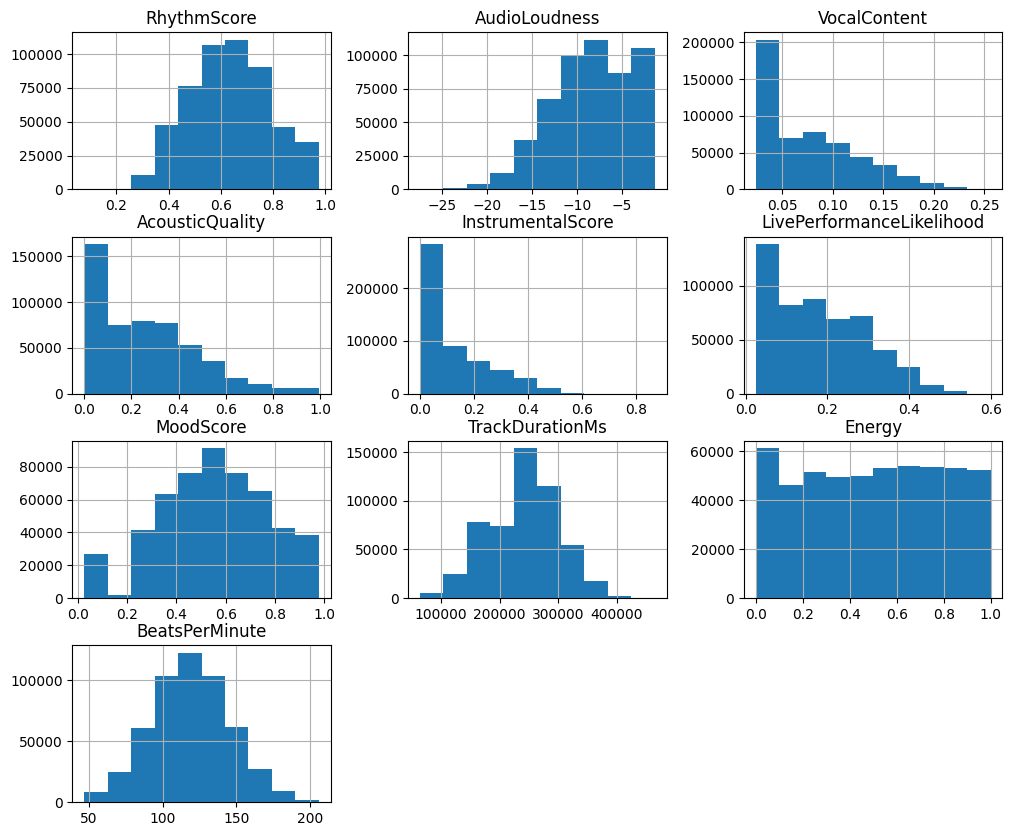

In [32]:
# Calculate.
kurt = df.kurtosis()
skew = df.skew()

# Combine.
summary = pd.concat([skew, kurt], axis=1)
summary.columns = ['Skewness', 'Kurtosis']

# Sort by skew.
summary = summary.sort_values('Skewness', ascending=False)

# Display.
print(f"se(skew) = {np.sqrt(6/len(df)):.4f}, se(kurt) = {np.sqrt(24/len(df)):.4f}")
print(f"Not very useful for n = {len(df):,} though.")
display(summary)

# Plot histograms.
hist = df.hist(figsize=(12, 10))
plt.show()

## 2.3. Correlation.

VocalContent                 0.003147
AcousticQuality              0.001283
Energy                       0.001202
LivePerformanceLikelihood    0.000646
RhythmScore                  0.000543
MoodScore                    0.000411
TrackDurationMs              0.000369
AudioLoudness                0.000035
InstrumentalScore            0.000000
Name: MutualInformation, dtype: float64

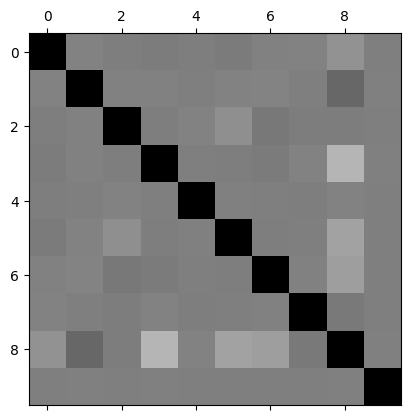

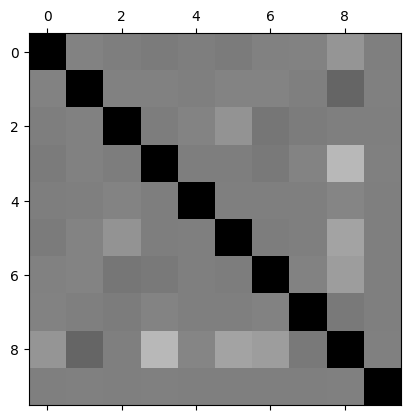

In [72]:
# Typical Pearson.
pearson = df.corr(method='pearson')
plt.matshow(pearson, cmap="gray_r", vmin=-1, vmax=1)

# Spearman.
pearson = df.corr(method='spearman')
plt.matshow(pearson, cmap="gray_r", vmin=-1, vmax=1)

# Mutual information.
from sklearn.feature_selection import mutual_info_regression
mi_vals = mutual_info_regression(X.values, np.asarray(y))
mi_series = pd.Series(mi_vals, index=X.columns, name="MutualInformation").sort_values(ascending=False)
display(mi_series)

# 3. Preprocessing.

## 3.1. Transform.

In [ ]:
# Apply log1p to reduce skewness.
cols_skewed      = ["InstrumentalScore", "VocalContent", "AcousticQuality"]

print("Before:")
display(df[cols_skewed].skew())

df_trans                = df.copy()
df_trans[cols_skewed]   = np.log1p(df_trans[cols_skewed])
X_trans                 = df_trans.drop(columns=['BeatsPerMinute'])

print("After:")
display(df_trans[cols_skewed].skew())

Before:


InstrumentalScore    1.036285
VocalContent         0.789112
AcousticQuality      0.785966
dtype: float64

After:


InstrumentalScore    0.869734
VocalContent         0.708348
AcousticQuality      0.430256
dtype: float64

## 3.2. Feature Scaling.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler     = StandardScaler()
X_scaled   = scaler.fit_transform(X_trans)
X_scaled   = pd.DataFrame(X_scaled, columns=X.columns)

display(X_scaled.head())

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,-0.186320,0.160753,-1.039091,-1.285378,-0.931999,-1.074691,-0.647405,0.822767,1.122062
1,0.042116,-1.708885,-0.036470,0.878609,1.734406,-0.066641,0.422064,-1.304377,-1.226143
2,-0.754022,-1.640859,0.749140,-0.343745,2.397472,-1.259230,-0.585321,-1.136222,0.426774
3,0.647674,1.521162,-0.418456,-1.275711,0.386437,-0.778712,-1.228925,-0.275361,-0.046407
4,-0.636554,-1.013259,-1.039091,-0.894828,-0.931999,1.294126,-0.346257,-0.471004,1.539602


## 3.3. Pipeline.

In [56]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Config.
target      = "BeatsPerMinute"
cols_skewed = ["InstrumentalScore", "VocalContent", "AcousticQuality"]

# Split features and target.
X = df.drop(columns=[target])
y = df[target]

# Column-wise log1p transformer.
log1p_ct = ColumnTransformer(
    transformers    = [("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), cols_skewed)],
    remainder       = "passthrough"
)

# Pipeline.
pipe = Pipeline([
    ("log1p", log1p_ct),
    ("scaler", StandardScaler())
])

# Transform features and keep original column order for convenience.
X_prep = pipe.fit_transform(X)
X_prep = pd.DataFrame(X_prep, columns=X.columns)

display(X_prep.head())


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,-0.931999,-1.039091,-1.285378,-0.186320,0.160753,-1.074691,-0.647405,0.822767,1.122062
1,1.734406,-0.036470,0.878609,0.042116,-1.708885,-0.066641,0.422064,-1.304377,-1.226143
2,2.397472,0.749140,-0.343745,-0.754022,-1.640859,-1.259230,-0.585321,-1.136222,0.426774
3,0.386437,-0.418456,-1.275711,0.647674,1.521162,-0.778712,-1.228925,-0.275361,-0.046407
4,-0.931999,-1.039091,-0.894828,-0.636554,-1.013259,1.294126,-0.346257,-0.471004,1.539602


# 4. Model Selection.

## 4.1. Simple Regressions.

- As expected, almost same as a `mean baseline`.
- Let's try some `nonlinear` models.

### 4.1.1. Linear Regression.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

n_splits    = 5
cv          = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

scores_a    = cross_val_score(LinearRegression(), X_prep, y, cv=cv, scoring="r2")

print(f"- R2 (5-fold CV): mean={scores_a.mean():.4f}, std={scores_a.std():.4f}.")
print("- Fold scores:", np.round(scores_a, 4))

- R2 (5-fold CV): mean=0.0001, std=0.0001.
- Fold scores: [ 0.0001  0.0001  0.0002  0.0003 -0.    ]


### 4.1.2. Polynomial Regression.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

for degree in range(1, 4):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_prep)

    scores = cross_val_score(LinearRegression(), X_poly, y, cv=cv, scoring="r2")
    print(f"- R2 (5-fold CV, degree={degree}): mean={scores.mean():.4f}, std={scores.std():.4f}.")
    print("- Fold scores:", np.round(scores, 4), end="\n\n")


- R2 (5-fold CV, degree=1): mean=0.0001, std=0.0001.
- Fold scores: [ 0.0001  0.0001  0.0002  0.0003 -0.    ]

- R2 (5-fold CV, degree=2): mean=0.0001, std=0.0001.
- Fold scores: [0.     0.0003 0.0002 0.0001 0.    ]

- R2 (5-fold CV, degree=3): mean=-0.0001, std=0.0001.
- Fold scores: [-0.0002  0.0001 -0.0003  0.0001 -0.0001]



## 4.2. GBDTs.

In [75]:
# Spearman, Mutual Information, and tree ensembles using existing X_prep, y, and cv.
# Assumes necessary common imports (e.g., numpy as np, pandas as pd, cross_val_score) are already available.
# Comments are in English and end with periods.

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

n_splits    = 2
cv          = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# 4) Tree ensembles with 5-fold CV R^2 on X_prep directly.
models = {
    "RandomForest": RandomForestRegressor(n_estimators=5, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=5, n_jobs=-1),
    "HistGBR": HistGradientBoostingRegressor(),
}

for name, model in models.items():
    scores = cross_val_score(model, X_prep, y, cv=cv, scoring="r2", n_jobs=-1)
    print(f"\n{name} - R2 (CV): mean={scores.mean():.4f}, std={scores.std():.4f}.")
    print(f"{name} - Fold scores:", np.round(scores, 4))



RandomForest - R2 (CV): mean=-0.2258, std=0.0021.
RandomForest - Fold scores: [-0.2237 -0.2279]

ExtraTrees - R2 (CV): mean=-0.2370, std=0.0002.
ExtraTrees - Fold scores: [-0.2368 -0.2372]

HistGBR - R2 (CV): mean=0.0004, std=0.0001.
HistGBR - Fold scores: [0.0003 0.0005]


# 5. Submission.

- Simple LR, 26.39115, 598/869.
- Ranking 1: 26.38276, 9/7, 2025.
- This competition is not valid at the moment. Maybe get back later.

In [78]:
# Read test and keep id for submission.
test = pd.read_csv("data/test.csv")
ids = test["id"].copy()

# Align test features to the training feature set.
if 'X' in globals():
    feature_cols = list(X.columns)
else:
    raise NameError("Expected `X` (training features) to exist. Define X before running this cell.")

X_test = test[feature_cols].copy()

# Choose estimator: prefer pipeline `pipe`, else fall back to `model_lin`.
if 'pipe' in globals():
    est = pipe
elif 'model_lin' in globals():
    est = model_lin
else:
    raise NameError("Expected a fitted estimator `pipe` (preferred) or `model_lin` to exist.")

# Fit on full training data, then predict on test.
est.fit(X, y)
y_pred = est.predict(X_test)

# Build and save submission.
sub = pd.DataFrame({"id": ids, "BeatsPerMinute": y_pred})
sub.to_csv("submission.csv", index=False)

# Quick preview.
print("Saved to submission.csv")
display(sub.head())


Saved to submission.csv


,id,BeatsPerMinute
0,524164,119.302183
1,524165,118.995771
2,524166,119.617660
3,524167,119.455987
4,524168,119.087860
